<h1>Scraping Toronto Postal Codes from Wikipedia</h1>

First we will import a few beneficial libraries.
<br>
* Numpy - array manipulation
* Pandas - DataFrame manipulation
* Requests - easier way to get html source code from a url
* BeautifulSoup - A html parser that will allow us to easily access the data inbetween html tags



In [3]:
import numpy as np
import pandas as pd
import requests as rq
from bs4 import BeautifulSoup as bs

We will store the link to our target page into a variable, url

In [4]:
#Storing URL & page title for potential later use
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
title='List of postal codes of Canada: M'

Using requests.get(targetpage).text we save the html source code of the page into variable html

In [5]:
#scraping plain text html of target page and storing in variable
html=rq.get(url).text

Now we utilize the BeautifulSoup methods with the lxml parsing engine. We use lxml as the page is not very complicated and want to optimize the speed of the calculation.<br><br>
Following that we use the .find method to find the tag that signifies the start of the HTML table (table) with the class wikitable sortable. As there is only one table the new variable will contain the data we are looking for.

In [6]:
#Assign text to soup object then Using beautiful soup package to isolate the wiki table
obj=bs(html,'lxml')
table=obj.find('table',{'class':'wikitable sortable'})

The variable table contains the data we want but not in a format we can use it. HTML builds tables one row at a time using the tr tag, then seperating the columns with the td tag. We can therefore use BeautifulSoup to extract the rows into a single list with the find_all method. After that we can simply run a for loop to create a nested list with each row. Once we have a nested list we can create a pandas dataframe using pd.DataFrame()

In [7]:
#Isolate table rows by html syntax tr
trrows=table.find_all('tr')

In [8]:
#create list object to assign all table rows to
l=[]

#run for loop to pull out each individual row to a seperate list and nest into list l
for tr in trrows:
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    l.append(row)
    
#Create Dataframe from nested list l
df=pd.DataFrame(l, columns=["Postal Code", "Borough",'Neighborhood'])
df.head()

,Postal Code,Borough,Neighborhood
0,None,None,None
1,M1A\n,Not assigned\n,Not assigned\n
2,M2A\n,Not assigned\n,Not assigned\n
3,M3A\n,North York\n,Parkwoods\n
4,M4A\n,North York\n,Victoria Village\n


At this stage we just need to clean our data set. First of we have a '\n' string attached to every data point. We remove this by using the series.str.replace() method from pandas. This is necessary as in the basestate the columns are all in object format.

In [9]:
#Clean dataset by stripping out \n
df['Postal Code']=df['Postal Code'].str.replace('\n','')
df['Borough']=df['Borough'].str.replace('\n','')
df['Neighborhood']=df['Neighborhood'].str.replace('\n','')

The first row contains no useful data and will be dropped by slicing the first index (0) off the dataframe

In [10]:
#Drop first row with None
df=df[1:]

Optional step here to see how many postal codes are assigned to each borough. it also shows how many rows we will drop containing 'Not assigned'

In [11]:
#see how many Not assigned boroughs exist
group=df.groupby(['Borough']).count()
group

,Postal Code,Neighborhood
Borough,,
Central Toronto,9,9
Downtown Toronto,19,19
East Toronto,5,5
East York,5,5
Etobicoke,12,12
Mississauga,1,1
North York,24,24
Not assigned,77,77
Scarborough,17,17


Using slicing of column borough not equal to not assigned we get a dataframe consisting of only postal codes + neighborhoods with named boroughs.

In [12]:
#Create a final dataframe to store all postal codes, boroughs and neighborhoods where Borough is not 'Not assigned'
df=df[df.Borough != 'Not assigned']
#Reset index sake good order
df=df.reset_index(drop=True)
df.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [13]:
#using .shape method to return total number of rows, columns to confirm correctly scraped table
df.shape

(103, 3)

<h1>Part 2 - Longitude + Latitude of Neigborhoods</h1>

Now we want to get the latitude and longitude of each postal code to be able to pass it to foursquare's API.<br><br>
First we import geocoder

In [14]:
!pip install --user geocoder

     |████████████████████████████████| 102kB 7.4MB/s ta 0:00:011
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [15]:
#from geopy.geocoders import Nominatim
#from geopy.extra.rate_limiter import RateLimiter
import geocoder
import time

#ALTERNATIVE METHOD PART 1
#Initialize Nominatim agent and create a locater with 1 second delay between queries to avoid timing out
#gloc=Nominatim(user_agent='CourseraCapstone')
#locator=RateLimiter(gloc.geocode,min_delay_seconds=2)

Now we need to use our free Bing developer API key to query the Bing service. I have it in a hidden cell to protect it. You can setup a Bing developer basic account at https://www.bingmapsportal.com/

In [16]:
# The code was removed by Watson Studio for sharing.

We initialize two Numpy arrays with 103 zeros (the number of total postal codes). Then run a for loop generating a json file for each query. We use the enumerate function to count the index numbers of the postal code to assign the correct latitude + longitude to the queried postal code.

In [17]:
lati=np.zeros(103)
longi=np.zeros(103)

for i,post in enumerate(df['Postal Code']):
    g=geocoder.bing('{}, Toronto, Ontario'.format(post),key=bingcred)
    lati[i]=g.lat
    longi[i]=g.lng

Finally we create 2 new columns based on our completed series and view the completed Dataframe. End of part 2

In [18]:
df['Latitude']=lati
df['Longitude']=longi
df.head(10)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.751881,-79.330360
1,M4A,North York,Victoria Village,43.730419,-79.312820
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.655140,-79.362648
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.723209,-79.451408
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.664490,-79.393021
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.662769,-79.528313
6,M1B,Scarborough,"Malvern, Rouge",43.811531,-79.195518
7,M3B,North York,Don Mills,43.749290,-79.361687
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.707939,-79.311600
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657360,-79.378181


In [19]:
#ALTERNATIVE METHOD PART 2
#df['query']=df['Postal Code']+', Toronto, Ontario'
#df['location']=df['query'].apply(locator)
#df.drop(['query'],axis=1,inplace=True)
#df.head()

<h1>Part 3 - Exploring Neighborhoods and letting K-Means Algorithm cluster our dataset</h1>

Initially we have to save our foursquare developer ID, API secret and version to query the foursquare database. This cell will be hidden.

In [20]:
# The code was removed by Watson Studio for sharing.

Import json to handle the output from foursquare queries.<br>
We now use a regex to filter down to only the central Toronto Boroughs to avoid querying foursquare too many times compared to what our API access allows.

In [21]:
import json

Toronto=df[df.Borough.str.match('.*Toronto.*')]
Toronto=Toronto.reset_index(drop=True)
Toronto.shape

(39, 5)

Loop through the remaining neighborhoods and pull venues within a 500 meter radius up to maximum 100. We assign these venues to a list and convert it into a dataframe.

In [22]:
# create the API request URL
venues_list=[]
radius=500
limit=100

for name, lat, lng in zip(Toronto['Neighborhood'], Toronto['Latitude'], Toronto['Longitude']):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius,
        limit
    )
    
    #make the GET request
    results = rq.get(url).json()["response"]['groups'][0]['items']

    venues_list.append([(
        name, 
        lat,
        lng,
        v['venue']['name'],
        v['venue']['location']['lat'], 
        v['venue']['location']['lng'],  
        v['venue']['categories'][0]['name']) for v in results])

    TorVen=pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    TorVen.columns = ['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue','Venue Latitude','Venue Longitude','Venue Category']

TorVen.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65514,-79.362648,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65514,-79.362648,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65514,-79.362648,Figs Breakfast & Lunch,43.655675,-79.364503,Breakfast Spot
3,"Regent Park, Harbourfront",43.65514,-79.362648,The Yoga Lounge,43.655515,-79.364955,Yoga Studio
4,"Regent Park, Harbourfront",43.65514,-79.362648,Body Blitz Spa East,43.654735,-79.359874,Spa


In [23]:
TorVen.shape

(1736, 7)

We have 1736 total venues.<br><br>
We can explore some types of venues with the loc function and see that there are quite a few coffee shops in Toronto. Expected for a city of this size.

In [24]:
Category=TorVen[['Neighborhood','Venue Category']].groupby(by='Venue Category').count()
coffee=TorVen.loc[TorVen['Venue Category']=='Coffee Shop']
park=TorVen.loc[TorVen['Venue Category']=='Park']
coffee=coffee.reset_index(drop=True)
park=park.reset_index(drop=True)
print('Coffee Places in Toronto = ',len(coffee.index),', Parks in Toronto = ', len(park.index))

Coffee Places in Toronto =  146 , Parks in Toronto =  35


I have decided to focus on Coffee Shops, Parks, Bars, Hotels, Liquor Stores and Gym/Fitness centers in an attempt to see if there is a difference in inner/outer Toronto between more local based venues and more tourist focused venues.<br>
Local = Parks, Liquor Stores, Coffee Shops, Bars, Gym/Fitness Centers<br>
Tourist = Coffee Shops, Bars, Hotels<br><br>
Assign our targeted venue types to a list to loop through. Initialize by testing on Coffee shops, then loop through the targets list with .loc to isolate the targeted venue type, groupby on neighborhoods to get the total number and then join it to the original dataframe on the neighborhood key.

In [25]:
targets=['Park','Bar','Hotel','Liquor Store','Gym / Fitness Center']
temp=TorVen[['Neighborhood','Venue Category']].loc[TorVen['Venue Category']=='Coffee Shop'].groupby(by='Neighborhood').count()
Tor3=Toronto.join(temp,on='Neighborhood')
Tor3.columns = ['Coffee Shop' if x=='Venue Category' else x for x in Tor3.columns]

for tar in targets:
    
    temp=TorVen[['Neighborhood','Venue Category']].loc[TorVen['Venue Category']==tar].groupby(by='Neighborhood').count()
    Tor3=Tor3.join(temp,on='Neighborhood')
    Tor3.columns = [tar if x=='Venue Category' else x for x in Tor3.columns]

Tor3=Tor3.fillna(0)
Tor3.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Coffee Shop,Park,Bar,Hotel,Liquor Store,Gym / Fitness Center
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.655140,-79.362648,5.0,0.0,0.0,0.0,0.0,1.0
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.664490,-79.393021,5.0,2.0,0.0,0.0,0.0,0.0
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657360,-79.378181,9.0,0.0,2.0,2.0,0.0,1.0
3,M5C,Downtown Toronto,St. James Town,43.651428,-79.375572,6.0,1.0,0.0,2.0,0.0,0.0
4,M4E,East Toronto,The Beaches,43.677029,-79.295418,0.0,0.0,0.0,0.0,0.0,0.0


We will now try to cluster the neighborhoods using K Means clustering. Avoid unnecessary columns by assigning only our numerical columns to the feat2 variable. I tested on the full feature list but concluded it was more correct to not attempt to cluster including latitude and longitude.<br> Normalize venue values with the Standard Scaler from scikit learn.

In [46]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

features=['Latitude','Longitude','Coffee Shop','Park','Bar','Hotel','Liquor Store','Gym / Fitness Center']
feat2=['Coffee Shop','Park','Bar','Hotel','Liquor Store','Gym / Fitness Center']
X=StandardScaler().fit_transform(Tor3[features])
X2=StandardScaler().fit_transform(Tor3[feat2])

Now we will attempt to find the most correct number of clusters to label using a combination of the elbow method and the silhouette score.

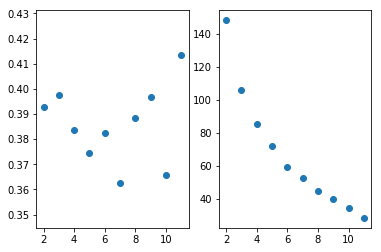

In [48]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

Cs=12
c_acc=np.zeros(10)
c_score=np.zeros(10)

for j,i in enumerate(range(2,Cs)):
    KMM=KMeans(n_clusters=i,random_state=10).fit(X2)
    labels=KMM.labels_
    c_acc[j]=silhouette_score(X2,labels)
    c_score[j]=abs(KMM.score(X2))

fig=plt.figure()
plt.subplot(1,2,1)    
plt.scatter(range(2,Cs),c_acc)
plt.subplot(1,2,2)
plt.scatter(range(2,Cs),c_score)
plt.show()

I have chosen 3 clusters as our final cluster number as it has a slightly higher silhouette score than 9 clusters and still passes the elbow test to a certain degree. I want to avoid over clustering and having very few neighborhoods per cluster to keep the clusters more generalized.<br><br>We run a final kmeans clustering algorithm and assign the labels to our final dataframe.

In [54]:
finclus=3
KMMfin=KMeans(n_clusters=finclus,random_state=10).fit(X2)
labels=KMMfin.labels_
Tor4=Tor3.copy()
Tor4['Labels']=labels
Tor4.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Coffee Shop,Park,Bar,Hotel,Liquor Store,Gym / Fitness Center,Labels
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.655140,-79.362648,5.0,0.0,0.0,0.0,0.0,1.0,2
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.664490,-79.393021,5.0,2.0,0.0,0.0,0.0,0.0,2
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657360,-79.378181,9.0,0.0,2.0,2.0,0.0,1.0,1
3,M5C,Downtown Toronto,St. James Town,43.651428,-79.375572,6.0,1.0,0.0,2.0,0.0,0.0,2
4,M4E,East Toronto,The Beaches,43.677029,-79.295418,0.0,0.0,0.0,0.0,0.0,0.0,2


We will now visualize the Neighborhoods on a map using folium

In [50]:
!pip install --user folium

     |████████████████████████████████| 102kB 8.3MB/s ta 0:00:011


First we initialize our map by centering it around Toronto. Then we create a color spectrum for the three clusters using matplotlib. Finally we add the neighborhood markers to the map by looping through latitude longitude, neighborhood name and cluster label.

In [64]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

#Find toronto latitude+longitude
g=geocoder.bing('Toronto, Ontario',key=bingcred)
mapstart=[g.lat,g.lng]
#Initialize folium map object centered around Toronto
tormap=folium.Map(location=mapstart,zoom_start=12,tiles='Stamen Toner')

# set color scheme for the clusters
x = np.arange(finclus)
ys = [i + x + (i*x)**2 for i in range(finclus)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Tor4['Latitude'], Tor4['Longitude'], Tor4['Neighborhood'], Tor4['Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(tormap)

In [65]:
tormap

<b>Cluster 0</b>

In [70]:
Tor4.loc[Tor4['Labels']==0]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Coffee Shop,Park,Bar,Hotel,Liquor Store,Gym / Fitness Center,Labels
5,M5E,Downtown Toronto,Berczy Park,43.645309,-79.373680,6.0,1.0,0.0,2.0,1.0,0.0,0
10,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.642849,-79.380402,7.0,2.0,0.0,4.0,1.0,0.0,0
15,M4L,East Toronto,"India Bazaar, The Beaches West",43.667969,-79.314682,1.0,2.0,0.0,0.0,1.0,0.0,0
24,M5R,Central Toronto,"The Annex, North Midtown, Yorkville",43.674839,-79.401848,1.0,2.0,0.0,0.0,1.0,0.0,0
28,M6S,West Toronto,"Runnymede, Swansea",43.650341,-79.475708,4.0,1.0,0.0,0.0,1.0,0.0,0
31,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",43.685692,-79.402321,2.0,0.0,0.0,0.0,1.0,0.0,0
35,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667881,-79.366493,3.0,2.0,0.0,0.0,1.0,1.0,0


Our first cluster, red, is heavily focused on liquor stores and parks. It is semi-central and could indicate areas that have more locals

<b>Cluster 1</b>

In [71]:
Tor4.loc[Tor4['Labels']==1]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Coffee Shop,Park,Bar,Hotel,Liquor Store,Gym / Fitness Center,Labels
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657360,-79.378181,9.0,0.0,2.0,2.0,0.0,1.0,1
6,M5G,Downtown Toronto,Central Bay Street,43.656090,-79.384933,7.0,1.0,1.0,2.0,0.0,1.0,1
8,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.649700,-79.382584,7.0,0.0,1.0,5.0,0.0,1.0,1
13,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647099,-79.381531,10.0,0.0,1.0,8.0,0.0,1.0,1
14,M6K,West Toronto,"Brockton, Parkdale Village, Exhibition Place",43.639408,-79.426758,5.0,1.0,5.0,1.0,0.0,0.0,1
16,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648232,-79.378899,9.0,1.0,1.0,6.0,0.0,1.0,1
32,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.640820,-79.399559,5.0,2.0,3.0,1.0,0.0,2.0,1
34,M5W,Downtown Toronto,Stn A PO Boxes,43.648689,-79.385437,7.0,1.0,2.0,5.0,0.0,1.0,1
36,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648281,-79.381462,12.0,0.0,2.0,7.0,0.0,1.0,1
38,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.648689,-79.385437,7.0,1.0,2.0,5.0,0.0,1.0,1


Our second cluster, purple, mostly focuses on coffee shops, bars and hotels. It is also very central to downtown Toronto and is much clearer that it has mostly Tourist visitors.

<b>Cluster 2</b>

In [73]:
Tor4.loc[Tor4['Labels']==2]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Coffee Shop,Park,Bar,Hotel,Liquor Store,Gym / Fitness Center,Labels
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.655140,-79.362648,5.0,0.0,0.0,0.0,0.0,1.0,2
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.664490,-79.393021,5.0,2.0,0.0,0.0,0.0,0.0,2
3,M5C,Downtown Toronto,St. James Town,43.651428,-79.375572,6.0,1.0,0.0,2.0,0.0,0.0,2
4,M4E,East Toronto,The Beaches,43.677029,-79.295418,0.0,0.0,0.0,0.0,0.0,0.0,2
7,M6G,Downtown Toronto,Christie,43.668781,-79.420708,1.0,0.0,0.0,0.0,0.0,0.0,2
9,M6H,West Toronto,"Dufferin, Dovercourt Village",43.665089,-79.438713,0.0,2.0,1.0,0.0,0.0,0.0,2
11,M6J,West Toronto,"Little Portugal, Trinity",43.648731,-79.417839,3.0,1.0,3.0,0.0,0.0,0.0,2
12,M4K,East Toronto,"The Danforth West, Riverdale",43.683750,-79.355278,1.0,1.0,0.0,0.0,0.0,0.0,2
17,M4M,East Toronto,Studio District,43.660912,-79.335030,3.0,1.0,2.0,0.0,0.0,0.0,2
18,M4N,Central Toronto,Lawrence Park,43.728981,-79.391731,0.0,1.0,0.0,0.0,0.0,0.0,2


Our third cluster, green, doesnt have any defining characteristics and would need to be granulated further with a broader feature set. Evidenced by some neighborhoods having 0 venues.

To improve our clustering we could either include more/all venue types or expand our foursquare search radius, both leading to more venues for each neighborhood leading to more accurate clustering.